# three-body choregraphy

In this notebook we will present some examples of three-body problem where the solution is remarquable and already done in this [gallery](http://three-body.ipb.ac.rs/).

We solve a restriction of $n$-body problem in 2 dimensions (we can remove $z$ direction without loss of generality). We note vector position $r_i=(x_i,y_i)$ of the mass $m_i$, $i=1,2,3$. The problem can be write as

$$
  \begin{aligned}
    \ddot{r}_1 &= -Gm_2\frac{r_1 - r_2}{|r_1-r_2|^3} - Gm_3\frac{r_1 - r_3}{|r_1-r_3|^3} \\
    \ddot{r}_2 &= -Gm_1\frac{r_2 - r_1}{|r_2-r_1|^3} - Gm_3\frac{r_2 - r_3}{|r_2-r_3|^3} \\
    \ddot{r}_3 &= -Gm_1\frac{r_3 - r_1}{|r_3-r_1|^3} - Gm_2\frac{r_3 - r_2}{|r_3-r_2|^3} \\
  \end{aligned}
$$

In the restriction we also set all mass to $1$: $m_i = 1$, $i=1,2,3$, and gravitational constant $G=1$ (the problem is nondimensioned).

Ponio is build to solve first order ODE, so we need to rewrite our problem with a change of variable:

$$
  \begin{aligned}
    \dot{y}_0 &= x_1 \\
    \dot{y}_1 &= y_1 \\
    \dot{y}_2 &= x_2 \\
    \dot{y}_3 &= y_2 \\
    \dot{y}_4 &= x_3 \\
    \dot{y}_5 &= y_3 \\
    \dot{y}_6 &= \dot{x}_1 \\
    \dot{y}_7 &= \dot{y}_1 \\
    \dot{y}_8 &= \dot{x}_2 \\
    \dot{y}_9 &= \dot{y}_2 \\
    \dot{y}_{10} &= \dot{x}_3 \\
    \dot{y}_{11} &= \dot{y}_3 \\
  \end{aligned}
$$

and the solve the problem done by

$$
  \begin{aligned}
    \dot{y}_0 &= \dot{y}_6 \\
    \dot{y}_1 &= \dot{y}_7 \\
    \dot{y}_2 &= \dot{y}_8 \\
    \dot{y}_3 &= \dot{y}_9 \\
    \dot{y}_4 &= \dot{y}_{10} \\
    \dot{y}_5 &= \dot{y}_{11} \\
    \dot{y}_6 &= - \frac{y_0 - y_2}{|r_1-r_2|^3} - \frac{y_0 - y_4}{|r_1-r_2|^3} \\
    \dot{y}_7 &= - \frac{y_1 - y_3}{|r_1-r_2|^3} - \frac{y_1 - y_5}{|r_1-r_2|^3} \\
    \dot{y}_8 &= - \frac{y_2 - y_0}{|r_1-r_2|^3} - \frac{y_2 - y_4}{|r_1-r_2|^3} \\
    \dot{y}_9 &= - \frac{y_3 - y_1}{|r_1-r_2|^3} - \frac{y_3 - y_5}{|r_1-r_2|^3} \\
    \dot{y}_{10} &= - \frac{y_4 - y_0}{|r_1-r_2|^3} - \frac{y_4 - y_2}{|r_1-r_2|^3} \\
    \dot{y}_{11} &= - \frac{y_5 - y_1}{|r_1-r_2|^3} - \frac{y_5 - y_3}{|r_1-r_2|^3} \\
  \end{aligned}
$$

with $r_1 = (y_0, y_1)$, $r_2 = (y_2, y_3)$ and $r_3 = (y_4, y_5)$.

In [1]:
%system mkdir -p three_body_choregraphy_demo

[]

In [2]:
%%writefile three_body_choregraphy_demo/main.cpp

#include <iostream>
#include <numeric>
#include <valarray>
#include <numbers>
#include <cstdlib>
#include <filesystem>

#include <solver/problem.hpp>
#include <solver/solver.hpp>
#include <solver/observer.hpp>
#include <solver/runge_kutta.hpp>

struct nbody_model
{
    using vector_t = std::valarray<double>;
    using state_t  = std::valarray<double>;
    
    double G;
    double m1, m2, m3;
    std::size_t ncoord;
  
    nbody_model()
    : G(1.), m1(1.), m2(1.), m3(1.), ncoord(2)
    {}
    
    vector_t frac( vector_t const& u )
    {
        double norm = 1./std::pow(std::sqrt(u[0]*u[0] + u[1]*u[1]),3);
        return norm*u;
    }
    
    state_t operator () (double t , state_t const& y)
    {
        vector_t r1={y[0*ncoord+0], y[0*ncoord+1]},
                 r2={y[1*ncoord+0], y[1*ncoord+1]},
                 r3={y[2*ncoord+0], y[2*ncoord+1]};
        vector_t dr1 = - G*m2*frac(r1-r2) - G*m3*frac(r1-r3);
        vector_t dr2 = - G*m3*frac(r2-r3) - G*m1*frac(r2-r1);
        vector_t dr3 = - G*m1*frac(r3-r1) - G*m2*frac(r3-r2);
        
       return {
           y[3*ncoord+0],y[3*ncoord+1],
           y[4*ncoord+0],y[4*ncoord+1],
           y[5*ncoord+0],y[5*ncoord+1],
           dr1[0],dr1[1],
           dr2[0],dr2[1],
           dr3[0],dr3[1]
       };
    }
};

int main(int argc, char** argv)
{
    auto A = nbody_model();
    auto nbody_model_pb  = ponio::make_simple_problem(A);
    
    std::filesystem::path output = "three_body_choregraphy_demo/orbit.txt";
    double tf = 10.0;
    nbody_model::state_t  yini;
    
    if (argc > 1) {
        output = argv[1];
        
        if (argc == 5) {
            double p1 = std::atof(argv[2]);
            double p2 = std::atof(argv[3]);
            tf = std::atof(argv[4]);
            
            yini = {
                -1,0,
                1,0,
                0,0,
                p1,p2,
                p1,p2,
                -2*p1,-2*p2
            };
        } else if (argc == 15) {
            double x1 = std::atof(argv[2]), y1 = std::atof(argv[3]);
            double x2 = std::atof(argv[4]), y2 = std::atof(argv[5]);
            double x3 = std::atof(argv[6]), y3 = std::atof(argv[7]);
            
            double vx1 = std::atof(argv[ 8]), vy1 = std::atof(argv[ 9]);
            double vx2 = std::atof(argv[10]), vy2 = std::atof(argv[11]);
            double vx3 = std::atof(argv[12]), vy3 = std::atof(argv[13]);
            
            tf = std::atof(argv[14]);
            
            yini = {
                x1, y1,
                x2, y2,
                x3, y3,
                vx1, vy1,
                vx2, vy2,
                vx3, vy3
            };
        }
    }

    double dt = 1e-5;

    ponio::solve(nbody_model_pb, ponio::runge_kutta::rk54_7m(1e-6), yini, {0.,tf}, dt, observer::file_observer(output) );
   
    return 0;
}

Writing three_body_choregraphy_demo/main.cpp


In [3]:
%system $CXX -std=c++20 -I ../include -I ${CONDA_PREFIX}/include three_body_choregraphy_demo/main.cpp -o three_body_choregraphy_demo/main

[]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import subprocess

def launch(label, *args):
    tf = args[-1]
    opt = args[:-1]
    if len(opt) == 2:
        args = "{} {}".format(*opt)
    else:
        args = "{} {} {} {} {} {} {} {} {} {} {} {}".format(*opt)
        
    cmd = subprocess.Popen("./three_body_choregraphy_demo/main three_body_choregraphy_demo/{}.txt {} {}".format(label,args,tf).split())
    cmd.wait()
    
    data = np.loadtxt("three_body_choregraphy_demo/{}.txt".format(label))
    t = data[:,0]
    x1 = data[:,2*0+1]
    y1 = data[:,2*0+2]
    x2 = data[:,2*1+1]
    y2 = data[:,2*1+2]
    x3 = data[:,2*2+1]
    y3 = data[:,2*2+2]
    
    plt.plot(x1, y1, "-", linewidth=1)
    plt.plot(x2, y2, "-", linewidth=1)
    plt.plot(x3, y3, "-", linewidth=1)
    
    plt.show()

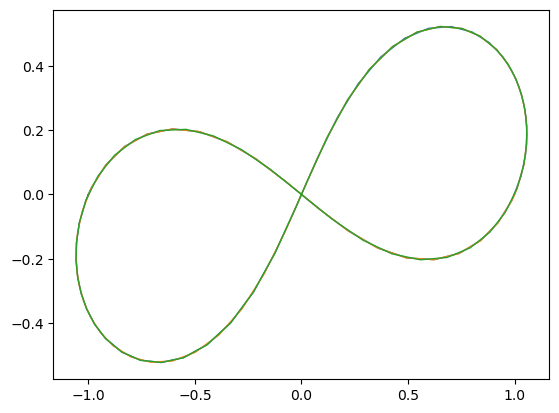

In [6]:
launch("figure8", 0.347111, 0.532728, 6.324449)

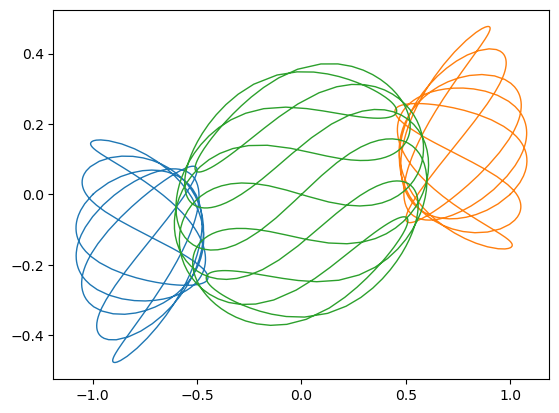

In [7]:
launch("butterflyIII", 0.405916, 0.230163, 13.865763)

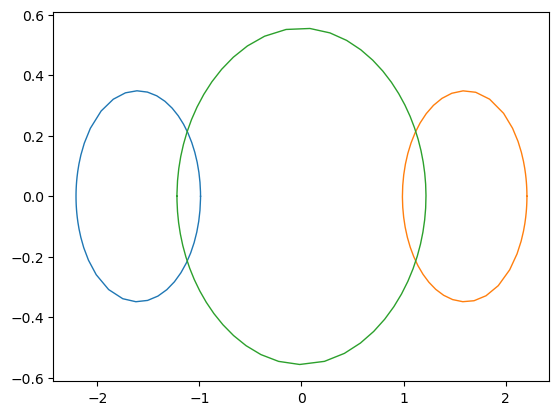

In [8]:
launch("BrouckeA1",
           -0.9892620043,0.0000000000,
           2.2096177241,0.0000000000,
           -1.2203557197,0.0000000000,
           0.0000000000,1.9169244185,
           0.0000000000,0.1910268738,
           0.0000000000,-2.1079512924
       , 6.283213)

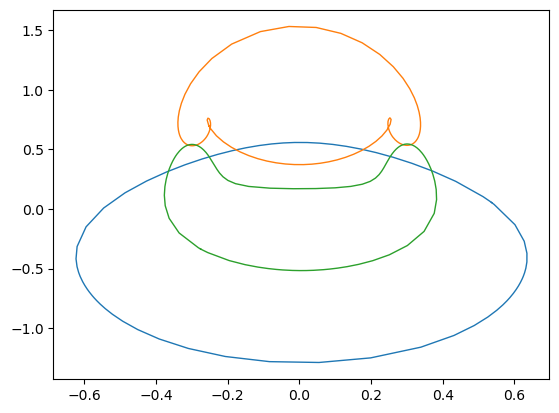

In [9]:
launch("ovals_catface_starship",
          0.536387073390, 0.054088605008,
          -0.252099126491, 0.694527327749,
          -0.275706601688, -0.335933589318,
          -0.569379585581, 1.255291102531,
          0.079644615252, -0.458625997341,
          0.489734970329, -0.796665105189
       , 5.026055)

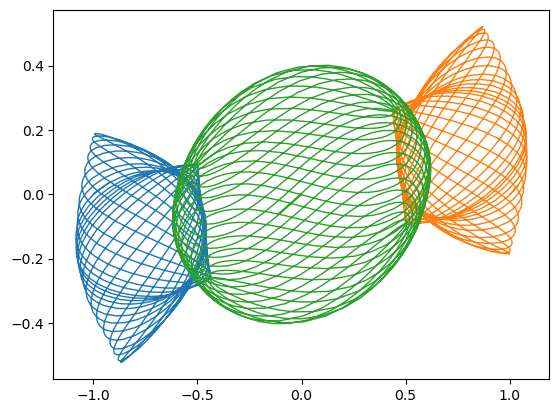

In [10]:
launch("butterflyI.12.A",
        0.408211,
        0.243685,
       48.486856)

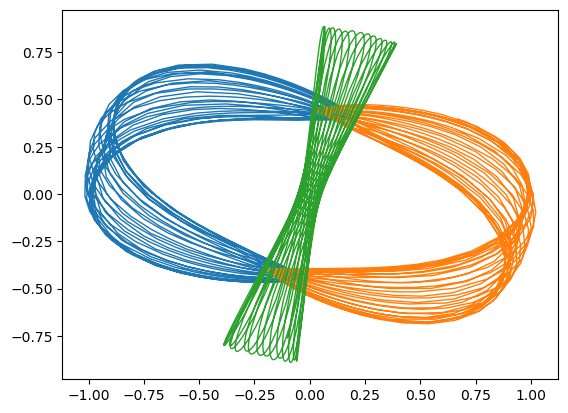

In [11]:
launch("dragonflyII.15.A",
        0.049051,
        0.590194,
       79.152719)

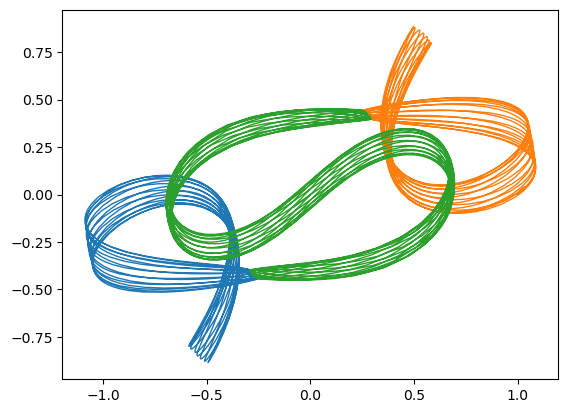

In [12]:
launch("yingyangIII.12.A.a",
        0.416822,
        0.330333,
       55.789329)

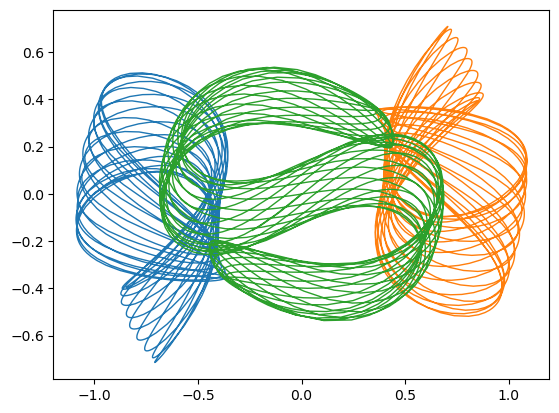

In [13]:
launch("yingyangIII.15.A.b",
        0.417701,
        0.303455,
       66.751098)

In [14]:
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.interpolate import interp1d

def anime(label):
    data = np.loadtxt("three_body_choregraphy_demo/{}.txt".format(label))
    t = data[:,0]
    success_t = (t[1:] - t[:-1]) != 0
    
    t1 = t[:-1][success_t]
    x1 = data[:,2*0+1][:-1][success_t]
    y1 = data[:,2*0+2][:-1][success_t]
    x2 = data[:,2*1+1][:-1][success_t]
    y2 = data[:,2*1+2][:-1][success_t]
    x3 = data[:,2*2+1][:-1][success_t]
    y3 = data[:,2*2+2][:-1][success_t]
    
    #plt.plot(x1[:-1][success_t],y1[:-1][success_t],lw=1)
    #plt.plot(x2[:-1][success_t],y2[:-1][success_t],lw=1)
    #plt.plot(x3[:-1][success_t],y3[:-1][success_t],lw=1)
    
    fx1 = interp1d(t1,x1,kind='cubic')
    fy1 = interp1d(t1,y1,kind='cubic')
    
    fx2 = interp1d(t1,x2,kind='cubic')
    fy2 = interp1d(t1,y2,kind='cubic')
    
    fx3 = interp1d(t1,x3,kind='cubic')
    fy3 = interp1d(t1,y3,kind='cubic')
    
    
    time = np.linspace(t1[0],t1[-1],2000)
    X1, Y1 = (fx1(time), fy1(time))
    X2, Y2 = (fx2(time), fy2(time))
    X3, Y3 = (fx3(time), fy3(time))
    
    number_of_frames = np.size(time)
    
    def update_plot(n):
        r1.set_data(X1[max(0,n-100):n+1],Y1[max(0,n-100):n+1])
        r2.set_data(X2[max(0,n-100):n+1],Y2[max(0,n-100):n+1])
        r3.set_data(X3[max(0,n-100):n+1],Y3[max(0,n-100):n+1])

        m1.set_data([X1[n]],[Y1[n]])
        m2.set_data([X2[n]],[Y2[n]])
        m3.set_data([X3[n]],[Y3[n]])

        ax.set_title("n = {}".format(n))
        return r1, r2, r3, m1, m2, m3
    
    fig = plt.figure()
    ax = plt.axes(xlim=(-1.5, 1.5), ylim=(-1.6, 1.6))
    r1, = ax.plot([], [], '-', lw=1, color="#686de0")
    r2, = ax.plot([], [], '-', lw=1, color="#ffbe76")
    r3, = ax.plot([], [], '-', lw=1, color="#badc58")

    m1, = ax.plot([], [], 'o', color="#4834d4")
    m2, = ax.plot([], [], 'o', color="#f0932b")
    m3, = ax.plot([], [], 'o', color="#6ab04c")

    ani = animation.FuncAnimation(fig, update_plot, frames=number_of_frames, repeat=False, interval=20 )
    plt.close()
    return HTML(ani.to_html5_video())
    
anime("yingyangIII.12.A.a")

In [15]:
anime("figure8")